In [21]:
import os
import pandas as pd

# Load all *_auto_eval.xls files
auto_eval_files = [f for f in os.listdir("./") if f.endswith("_auto_eval.xls")]
df_list = []

for file in auto_eval_files:
    try:
        model = file.replace("_auto_eval.xls", "")
        
        # First try reading as Excel
        try:
            df = pd.read_excel(file, engine='xlrd')  # For .xls
        except:
            try:
                df = pd.read_excel(file, engine='openpyxl')  # For .xlsx
            except:
                # If Excel fails, try reading as CSV
                try:
                    df = pd.read_csv(file)
                    print(f"⚠️ Loaded {file} as CSV (not Excel)")
                except Exception as e:
                    raise ValueError(f"File is neither valid Excel nor CSV: {file}") from e
        
        df["model"] = model
        df_list.append(df)
        print(f"✅ Successfully loaded {file}")
        
    except Exception as e:
        print(f"❌ Failed to load {file}: {str(e)}")
        # Try to inspect the file
        try:
            with open(file, 'rb') as f:
                header = f.read(4)
                print(f"   File header: {header} (first 4 bytes)")
        except Exception as ie:
            print(f"   Could not inspect file: {str(ie)}")

if df_list:
    all_auto_df = pd.concat(df_list, ignore_index=True)
    print(f"\n✅ Successfully loaded {len(df_list)}/{len(auto_eval_files)} files")
    print("First few rows:")
    print(all_auto_df.head())
else:
    print("\n❌ No files were successfully loaded")
    print("Possible solutions:")
    print("1. Verify files are valid Excel/CSV (may be corrupted)")
    print("2. Check file extensions match actual format")
    print("3. Try opening one manually to check format")
    print("4. Files might be TSV (tab-separated) instead of CSV")

⚠️ Loaded gemma3-27b_auto_eval.xls as CSV (not Excel)
✅ Successfully loaded gemma3-27b_auto_eval.xls
⚠️ Loaded gpt4_auto_eval.xls as CSV (not Excel)
✅ Successfully loaded gpt4_auto_eval.xls
⚠️ Loaded qwen2.5-latest_auto_eval.xls as CSV (not Excel)
✅ Successfully loaded qwen2.5-latest_auto_eval.xls
⚠️ Loaded mistral-small3.1-latest_auto_eval.xls as CSV (not Excel)
✅ Successfully loaded mistral-small3.1-latest_auto_eval.xls
⚠️ Loaded qwen3-0.6b_auto_eval.xls as CSV (not Excel)
✅ Successfully loaded qwen3-0.6b_auto_eval.xls
⚠️ Loaded qwen3-latest_auto_eval.xls as CSV (not Excel)
✅ Successfully loaded qwen3-latest_auto_eval.xls
⚠️ Loaded llama4-400b_auto_eval.xls as CSV (not Excel)
✅ Successfully loaded llama4-400b_auto_eval.xls
⚠️ Loaded deepseek-r1-70b-alt_auto_eval.xls as CSV (not Excel)
✅ Successfully loaded deepseek-r1-70b-alt_auto_eval.xls

✅ Successfully loaded 8/8 files
First few rows:
   id          condition       model  \
0  97          chat_only  gemma3-27b   
1  97       perso

<Figure size 1200x600 with 0 Axes>

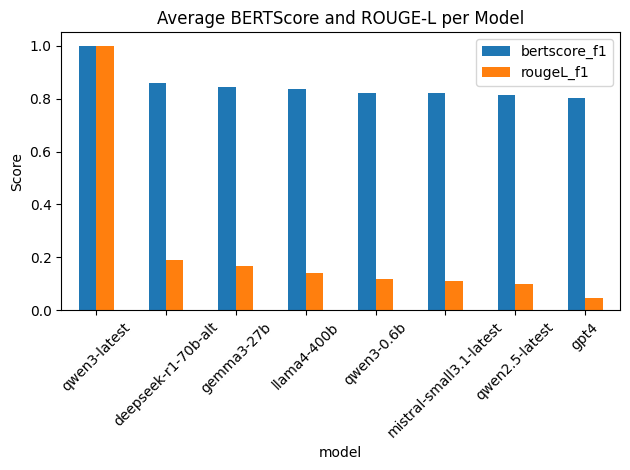

In [23]:
import matplotlib.pyplot as plt

mean_scores = all_auto_df.groupby("model")[["bertscore_f1", "rougeL_f1"]].mean().sort_values("bertscore_f1", ascending=False)

plt.figure(figsize=(12, 6))
mean_scores.plot(kind="bar", rot=45)
plt.title("Average BERTScore and ROUGE-L per Model")
plt.ylabel("Score")
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("avg_scores_per_model.png", dpi=300)
plt.show()


<Figure size 1400x600 with 0 Axes>

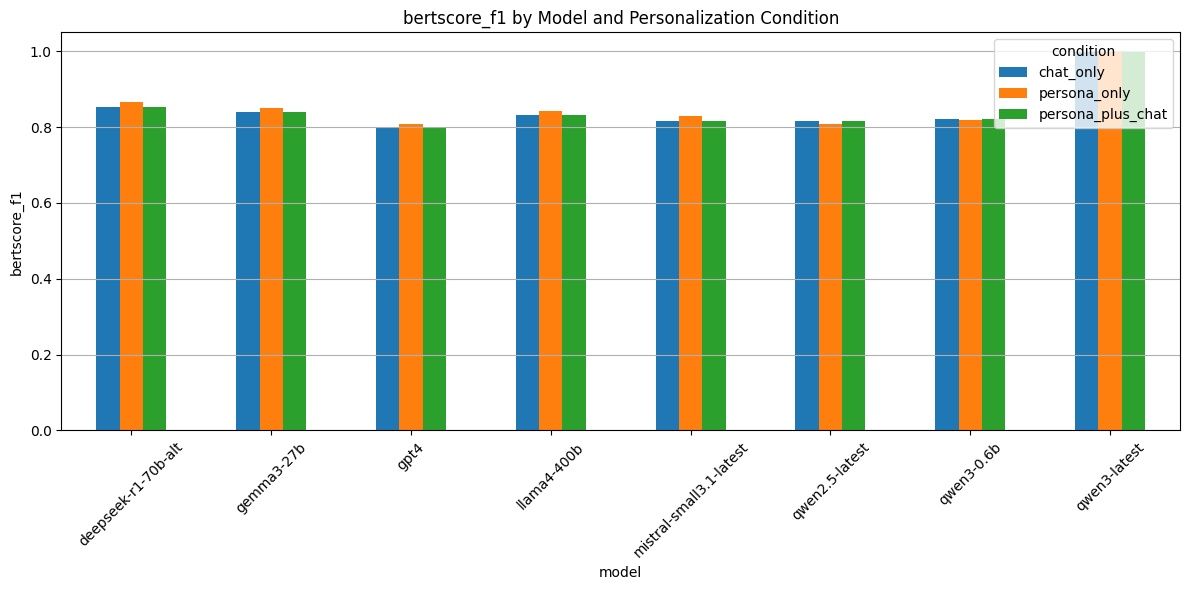

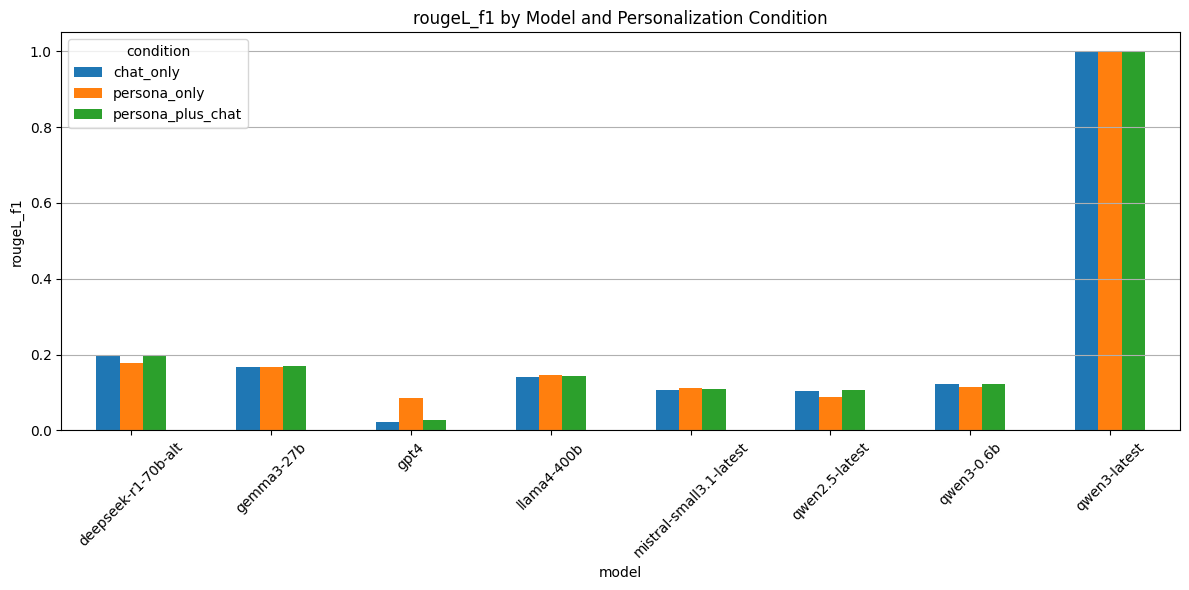

In [24]:
condition_means = all_auto_df.groupby(["model", "condition"])[["bertscore_f1", "rougeL_f1"]].mean().reset_index()

plt.figure(figsize=(14, 6))
for score in ["bertscore_f1", "rougeL_f1"]:
    pivot = condition_means.pivot(index="model", columns="condition", values=score)
    pivot.plot(kind="bar", figsize=(12, 6))
    plt.title(f"{score} by Model and Personalization Condition")
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.savefig(f"{score}_by_condition.png", dpi=300)
    plt.show()


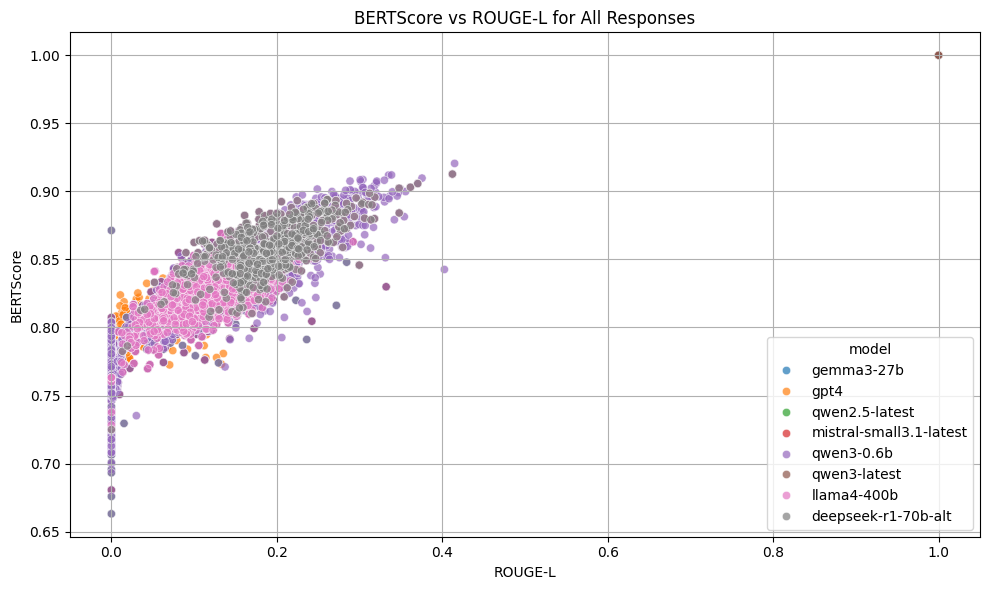

In [25]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_auto_df, x="rougeL_f1", y="bertscore_f1", hue="model", alpha=0.7)
plt.title("BERTScore vs ROUGE-L for All Responses")
plt.xlabel("ROUGE-L")
plt.ylabel("BERTScore")
plt.grid(True)
plt.tight_layout()
plt.savefig("semantic_vs_lexical.png", dpi=300)
plt.show()


Correlation between BERTScore and ROUGE-L:
              bertscore_f1  rougeL_f1
bertscore_f1      1.000000   0.882674
rougeL_f1         0.882674   1.000000


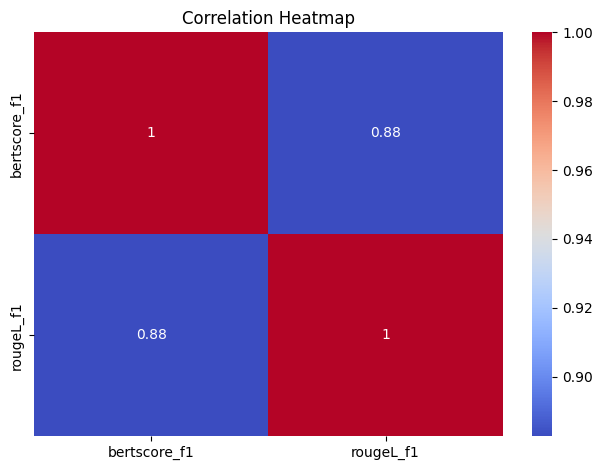

In [26]:
print("Correlation between BERTScore and ROUGE-L:")
corr = all_auto_df[["bertscore_f1", "rougeL_f1"]].corr()
print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)
plt.show()


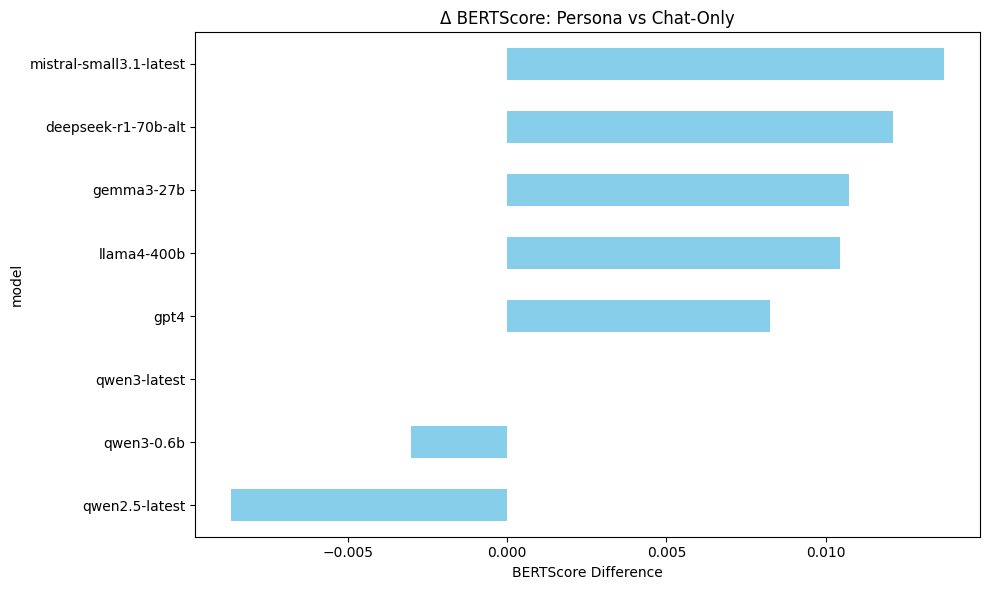

In [27]:
pivot = all_auto_df.pivot_table(index="model", columns="condition", values="bertscore_f1", aggfunc="mean")

pivot["delta_persona_vs_chat"] = pivot.get("persona_only", 0) - pivot.get("chat_only", 0)

pivot["delta_persona_vs_chat"].sort_values().plot(kind="barh", color="skyblue", figsize=(10, 6))
plt.title("Δ BERTScore: Persona vs Chat-Only")
plt.xlabel("BERTScore Difference")
plt.tight_layout()
plt.savefig("persona_vs_chat_delta.png", dpi=300)
plt.show()


In [28]:
agg = all_auto_df.groupby(["model", "condition"])[["bertscore_f1", "rougeL_f1"]].mean()
agg.to_csv("aggregated_auto_eval_summary.csv")
print("📄 Saved summary to aggregated_auto_eval_summary.csv")


📄 Saved summary to aggregated_auto_eval_summary.csv


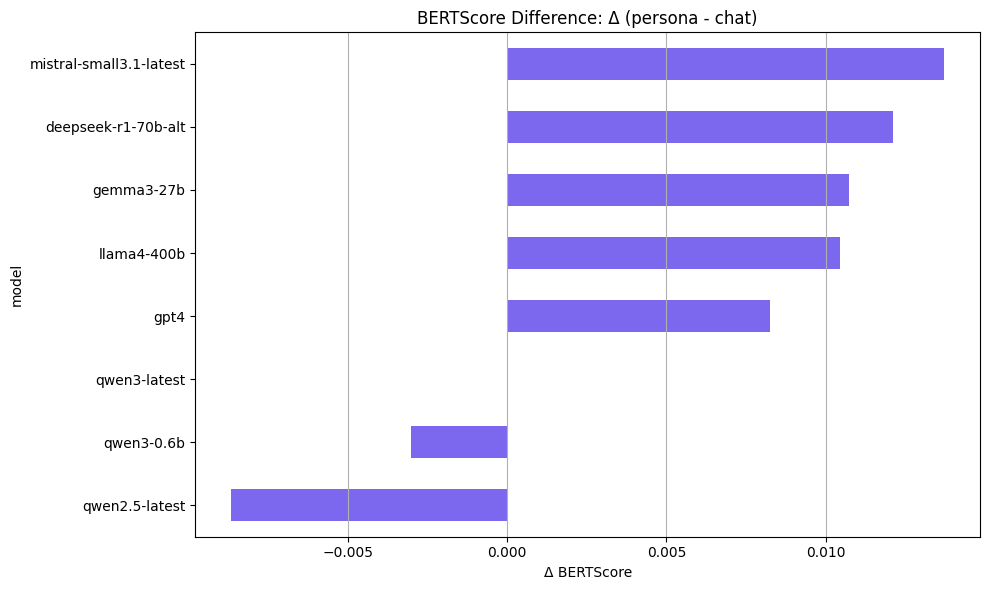

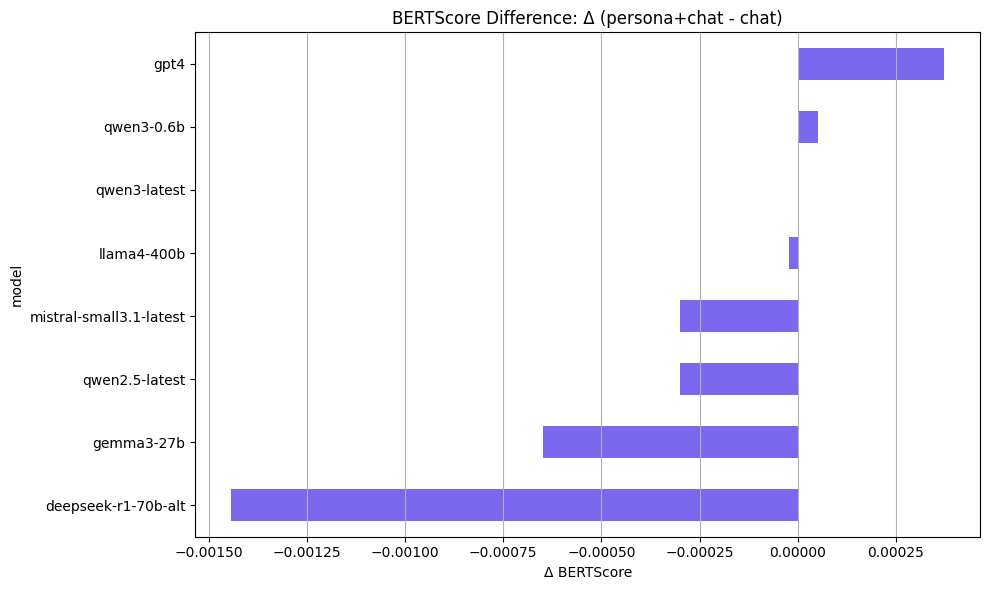

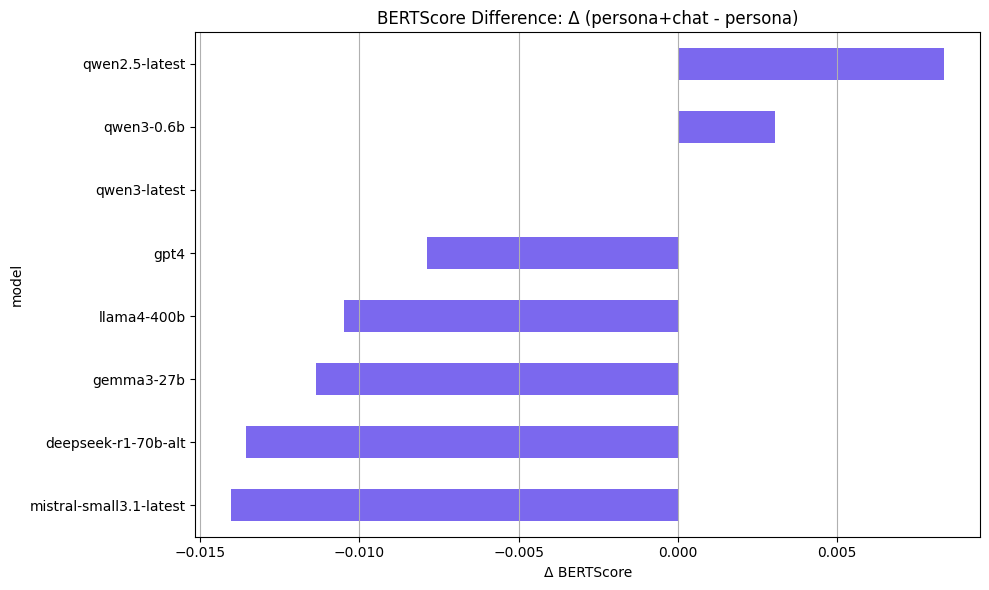

In [29]:
# Pivot table
pivot = all_auto_df.pivot_table(index="model", columns="condition", values="bertscore_f1", aggfunc="mean")

# Fill missing values (some models may lack a condition)
pivot = pivot.fillna(0)

# Compute all condition deltas
pivot["Δ (persona - chat)"] = pivot.get("persona_only", 0) - pivot.get("chat_only", 0)
pivot["Δ (persona+chat - chat)"] = pivot.get("persona_plus_chat", 0) - pivot.get("chat_only", 0)
pivot["Δ (persona+chat - persona)"] = pivot.get("persona_plus_chat", 0) - pivot.get("persona_only", 0)

# Plot each delta as horizontal bar
for col in ["Δ (persona - chat)", "Δ (persona+chat - chat)", "Δ (persona+chat - persona)"]:
    pivot[col].sort_values().plot(kind="barh", figsize=(10, 6), color="mediumslateblue")
    plt.title(f"BERTScore Difference: {col}")
    plt.xlabel("Δ BERTScore")
    plt.grid(True, axis="x")
    plt.tight_layout()
    plt.savefig(f"bert_score_diff_{col.replace(' ', '_').replace('(', '').replace(')', '').replace('+', 'plus')}.png", dpi=300)
    plt.show()


In [30]:
# Group mean scores by model and condition
summary_table = all_auto_df.groupby(["model", "condition"])[["bertscore_f1", "rougeL_f1"]].mean().round(4).reset_index()

# Pivot to wide format for table-like presentation
summary_wide = summary_table.pivot(index="model", columns="condition", values=["bertscore_f1", "rougeL_f1"])

# Flatten column names for better readability
summary_wide.columns = [f"{metric}_{cond}" for metric, cond in summary_wide.columns]
summary_wide = summary_wide.reset_index()

# Save table
summary_wide.to_csv("summary_scores_by_model_and_condition.csv", index=False)

import pandas as pd
from IPython.display import display
display(summary_wide.head(10))  # Show first few rows in notebook


,model,bertscore_f1_chat_only,bertscore_f1_persona_only,bertscore_f1_persona_plus_chat,rougeL_f1_chat_only,rougeL_f1_persona_only,rougeL_f1_persona_plus_chat
0,deepseek-r1-70b-alt,0.8542,0.8663,0.8527,0.1979,0.1773,0.1994
1,gemma3-27b,0.8394,0.8502,0.8388,0.1672,0.1686,0.1698
2,gpt4,0.8009,0.8092,0.8013,0.0232,0.0860,0.0279
3,llama4-400b,0.8323,0.8427,0.8322,0.1399,0.1451,0.1436
4,mistral-small3.1-latest,0.8164,0.8301,0.8161,0.1075,0.1130,0.1097
5,qwen2.5-latest,0.8161,0.8074,0.8158,0.1042,0.0888,0.1053
6,qwen3-0.6b,0.8222,0.8192,0.8222,0.1214,0.1159,0.1236
7,qwen3-latest,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [11]:
# Pivot for ROUGE-L
pivot_r = all_auto_df.pivot_table(index="model", columns="condition", values="rougeL_f1", aggfunc="mean").fillna(0)

# Compute deltas
pivot_r["Δ (persona - chat)"] = pivot_r.get("persona_only", 0) - pivot_r.get("chat_only", 0)
pivot_r["Δ (persona+chat - chat)"] = pivot_r.get("persona_plus_chat", 0) - pivot_r.get("chat_only", 0)
pivot_r["Δ (persona+chat - persona)"] = pivot_r.get("persona_plus_chat", 0) - pivot_r.get("persona_only", 0)


,bert_score_gain,rougeL_gain,average_gain
model,,,
llama4-400b,-0.0000,0.0037,0.0019
qwen3-0.6b,0.0001,0.0022,0.0011
gemma3-27b,-0.0006,0.0026,0.0010
mistral-small3.1-latest,-0.0003,0.0022,0.0009
qwen2.5-latest,-0.0003,0.0012,0.0004
deepseek-r1-70b-alt,-0.0014,0.0015,0.0000
gpt4,0.0004,NaN,NaN
qwen3-latest,-0.0000,NaN,NaN


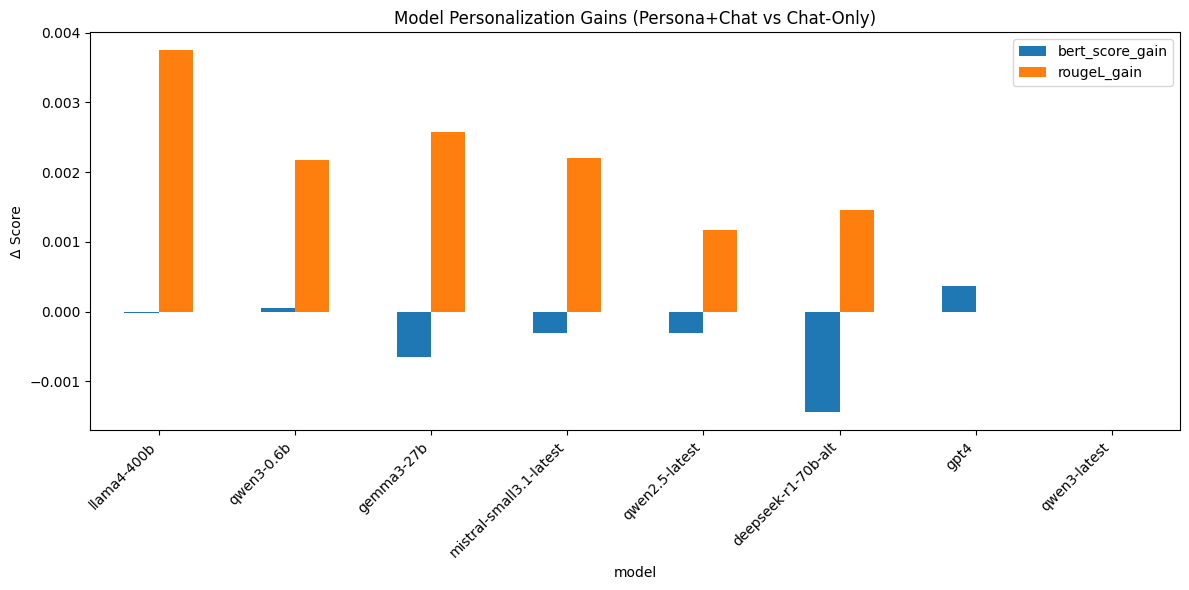

In [31]:
# Compute deltas from previous pivots
delta_bert = pivot["Δ (persona+chat - chat)"]
delta_rouge = pivot_r["Δ (persona+chat - chat)"]

# Combine into one DataFrame
ranking_df = pd.DataFrame({
    "bert_score_gain": delta_bert,
    "rougeL_gain": delta_rouge,
    "average_gain": (delta_bert + delta_rouge) / 2
}).sort_values("average_gain", ascending=False)

# Display and save
display(ranking_df.round(4))
ranking_df.to_csv("model_personalization_gains.csv")

# Plot ranking
ranking_df[["bert_score_gain", "rougeL_gain"]].plot(kind="bar", figsize=(12, 6))
plt.title("Model Personalization Gains (Persona+Chat vs Chat-Only)")
plt.ylabel("Δ Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("personalization_gain_barplot.png", dpi=300)
plt.show()


,bert_score_gain,rougeL_gain,average_gain
model,,,
qwen2.5-latest,0.0084,0.0165,0.0124
qwen3-0.6b,0.0031,0.0078,0.0054
deepseek-r1-70b-alt,-0.0136,0.0221,0.0043
gemma3-27b,-0.0114,0.0012,-0.0051
llama4-400b,-0.0105,-0.0015,-0.0060
mistral-small3.1-latest,-0.0140,-0.0033,-0.0087


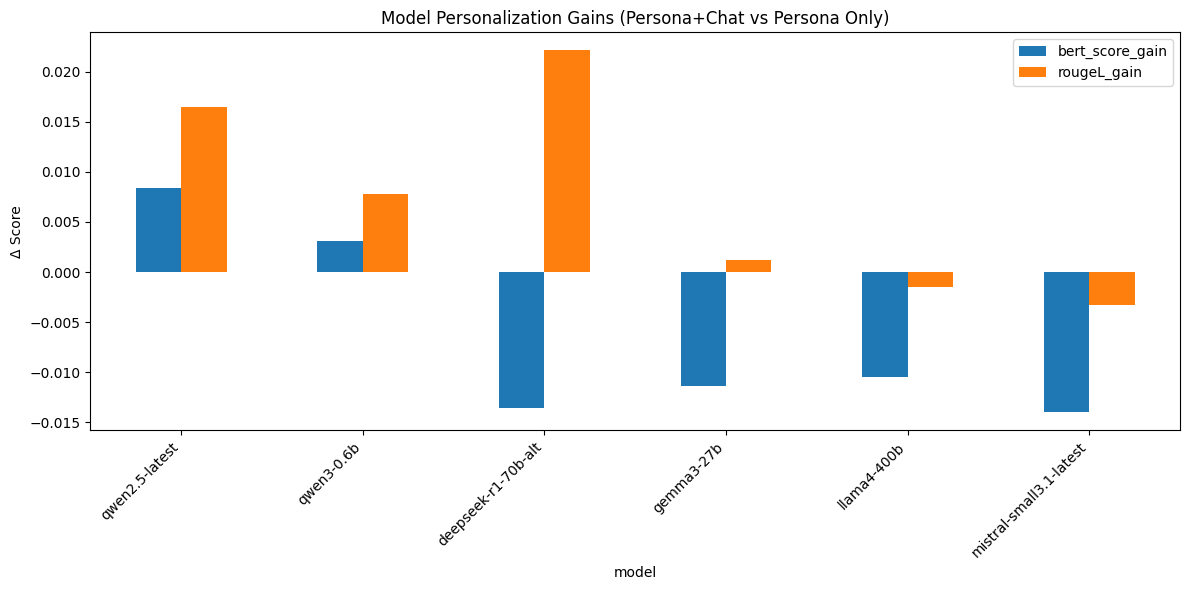

In [13]:
# Compute deltas from previous pivots
delta_bert = pivot["Δ (persona+chat - persona)"]
delta_rouge = pivot_r["Δ (persona+chat - persona)"]

# Combine into one DataFrame
ranking_df = pd.DataFrame({
    "bert_score_gain": delta_bert,
    "rougeL_gain": delta_rouge,
    "average_gain": (delta_bert + delta_rouge) / 2
}).sort_values("average_gain", ascending=False)

# Display and save
display(ranking_df.round(4))
ranking_df.to_csv("model_personalization_gains.csv")

# Plot ranking
ranking_df[["bert_score_gain", "rougeL_gain"]].plot(kind="bar", figsize=(12, 6))
plt.title("Model Personalization Gains (Persona+Chat vs Persona Only)")
plt.ylabel("Δ Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("personalizationpcp_gain_barplot.png", dpi=300)
plt.show()

,bert_score_gain,rougeL_gain,average_gain
model,,,
mistral-small3.1-latest,0.0137,0.0055,0.0096
llama4-400b,0.0104,0.0052,0.0078
gemma3-27b,0.0107,0.0013,0.0060
deepseek-r1-70b-alt,0.0121,-0.0207,-0.0043
qwen3-0.6b,-0.0030,-0.0056,-0.0043
qwen2.5-latest,-0.0087,-0.0153,-0.0120
gpt4,0.0083,NaN,NaN
qwen3-latest,-0.0000,NaN,NaN


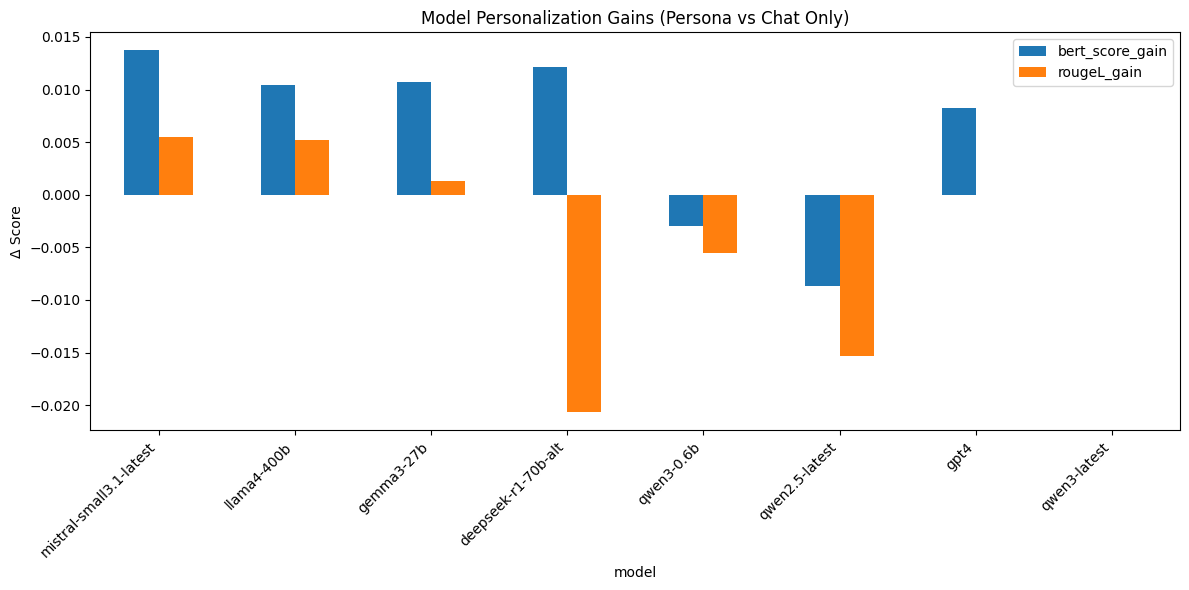

In [32]:
# Compute deltas from previous pivots
delta_bert = pivot["Δ (persona - chat)"]
delta_rouge = pivot_r["Δ (persona - chat)"]

# Combine into one DataFrame
ranking_df = pd.DataFrame({
    "bert_score_gain": delta_bert,
    "rougeL_gain": delta_rouge,
    "average_gain": (delta_bert + delta_rouge) / 2
}).sort_values("average_gain", ascending=False)

# Display and save
display(ranking_df.round(4))
ranking_df.to_csv("model_personalization_gains.csv")

# Plot ranking
ranking_df[["bert_score_gain", "rougeL_gain"]].plot(kind="bar", figsize=(12, 6))
plt.title("Model Personalization Gains (Persona vs Chat Only)")
plt.ylabel("Δ Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("personalizationpc_gain_barplot.png", dpi=300)
plt.show()

In [33]:
# Standard deviation of scores across conditions
bert_consistency = all_auto_df.pivot_table(index="model", columns="condition", values="bertscore_f1", aggfunc="std")
rouge_consistency = all_auto_df.pivot_table(index="model", columns="condition", values="rougeL_f1", aggfunc="std")

# Lower std = more consistent
display(bert_consistency.sort_values("persona_plus_chat"))
display(rouge_consistency.sort_values("persona_plus_chat"))


condition,chat_only,persona_only,persona_plus_chat
model,,,
qwen3-latest,1.664117e-08,4.870487e-08,1.906091e-08
gpt4,9.828880e-03,1.688875e-02,9.498505e-03
deepseek-r1-70b-alt,1.507780e-02,2.268756e-02,1.505589e-02
gemma3-27b,1.976485e-02,2.473769e-02,1.922359e-02
llama4-400b,2.138896e-02,2.481412e-02,2.092977e-02
qwen2.5-latest,2.903109e-02,5.285339e-02,2.914456e-02
qwen3-0.6b,2.968705e-02,5.509672e-02,3.006202e-02
mistral-small3.1-latest,3.230202e-02,3.323849e-02,3.236315e-02


condition,chat_only,persona_only,persona_plus_chat
model,,,
qwen3-latest,0.000000,0.000000,0.000000
gpt4,0.011976,0.042231,0.014805
deepseek-r1-70b-alt,0.038838,0.067562,0.037186
gemma3-27b,0.045516,0.053426,0.044553
llama4-400b,0.057909,0.059144,0.056109
qwen2.5-latest,0.066504,0.080214,0.066965
mistral-small3.1-latest,0.072584,0.074149,0.072980
qwen3-0.6b,0.071942,0.095717,0.073830


In [34]:
gains_df = pd.DataFrame({
    "persona_only vs chat_only (BERT)": pivot["persona_only"] - pivot["chat_only"],
    "persona_plus_chat vs chat_only (BERT)": pivot["persona_plus_chat"] - pivot["chat_only"],
    "persona_plus_chat vs persona_only (BERT)": pivot["persona_plus_chat"] - pivot["persona_only"],
    "persona_only vs chat_only (ROUGE)": pivot_r["persona_only"] - pivot_r["chat_only"],
    "persona_plus_chat vs chat_only (ROUGE)": pivot_r["persona_plus_chat"] - pivot_r["chat_only"],
    "persona_plus_chat vs persona_only (ROUGE)": pivot_r["persona_plus_chat"] - pivot_r["persona_only"]
})
display(gains_df.round(4))
gains_df.to_csv("persona_sensitivity_metrics.csv")


,persona_only vs chat_only (BERT),persona_plus_chat vs chat_only (BERT),persona_plus_chat vs persona_only (BERT),persona_only vs chat_only (ROUGE),persona_plus_chat vs chat_only (ROUGE),persona_plus_chat vs persona_only (ROUGE)
model,,,,,,
deepseek-r1-70b-alt,0.0121,-0.0014,-0.0136,-0.0207,0.0015,0.0221
gemma3-27b,0.0107,-0.0006,-0.0114,0.0013,0.0026,0.0012
gpt4,0.0083,0.0004,-0.0079,NaN,NaN,NaN
llama4-400b,0.0104,-0.0000,-0.0105,0.0052,0.0037,-0.0015
mistral-small3.1-latest,0.0137,-0.0003,-0.0140,0.0055,0.0022,-0.0033
qwen2.5-latest,-0.0087,-0.0003,0.0084,-0.0153,0.0012,0.0165
qwen3-0.6b,-0.0030,0.0001,0.0031,-0.0056,0.0022,0.0078
qwen3-latest,-0.0000,-0.0000,0.0000,NaN,NaN,NaN


In [35]:
from scipy.stats import pearsonr

corr, _ = pearsonr(all_auto_df["bertscore_f1"], all_auto_df["rougeL_f1"])
print(f"Correlation between BERTScore and ROUGE-L: r = {corr:.3f}")


Correlation between BERTScore and ROUGE-L: r = 0.883


In [36]:
bert_bonus_eff = (pivot["persona_plus_chat"] - pivot["chat_only"]) / (pivot["persona_plus_chat"] - pivot["persona_only"] + 1e-6)
rouge_bonus_eff = (pivot_r["persona_plus_chat"] - pivot_r["chat_only"]) / (pivot_r["persona_plus_chat"] - pivot_r["persona_only"] + 1e-6)

eff_df = pd.DataFrame({
    "BERT Bonus Efficiency": bert_bonus_eff,
    "ROUGE Bonus Efficiency": rouge_bonus_eff
}).sort_values("BERT Bonus Efficiency", ascending=False)

display(eff_df.round(3))


,BERT Bonus Efficiency,ROUGE Bonus Efficiency
model,,
deepseek-r1-70b-alt,0.106,0.066
gemma3-27b,0.057,2.057
mistral-small3.1-latest,0.021,-0.666
qwen3-0.6b,0.017,0.281
llama4-400b,0.002,-2.546
qwen3-latest,-0.000,NaN
qwen2.5-latest,-0.036,0.071
gpt4,-0.047,NaN
